## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
#%matplotlib inline Again, doesn't play well with jupyter lab
import matplotlib.pyplot as plt

import tensorflow as tf
from itertools import chain
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

%matplotlib inline

## TODO list
* Consider normalization
* Do we want to restrict age at all? Should we?
* It might be the case that we should turn these cleaning steps into function for use later. 
* Consider balancing more crap when performing splits


## Do some early processing of your metadata for easier model training:

In [29]:
!ls -ltr

total 18392
-rw-rw-r--  1 jared jared 8963138 Sep 25  2019  ARXIV_V5_CHESTXRAY.pdf
-rw-rw-r--  1 jared jared   92416 Sep 25  2019  BBox_List_2017.csv
-rw-rw-r--  1 jared jared  847223 Sep 25  2019  README_CHESTXRAY.pdf
-rw-rw-r--  1 jared jared    3919 Sep 25  2019  LOG_CHESTXRAY.pdf
-rw-rw-r--  1 jared jared   72223 Sep 25  2019  FAQ_CHESTXRAY.pdf
-rw-rw-r--  1 jared jared 1470907 Sep 25  2019  train_val_list.txt
-rw-rw-r--  1 jared jared  435131 Sep 25  2019  test_list.txt
-rw-rw-r--  1 jared jared  432125 Dec  4 14:48  sample_labels.csv
-rw-rw-r--  1 jared jared   12465 Dec  4 14:48  README.md
-rw-rw-r--  1 jared jared    1158 Dec  4 14:48  FDA_Submission_Template.md
-rw-rw-r--  1 jared jared 1049354 Dec  4 14:48  test1.dcm
-rw-rw-r--  1 jared jared 1049356 Dec  4 14:48  test2.dcm
-rw-rw-r--  1 jared jared 1049352 Dec  4 14:48  test3.dcm
-rw-rw-r--  1 jared jared 1049356 Dec  4 14:48  test4.dcm
-rw-rw-r--  1 jared jared 1049354 Dec  4 14:48  test5.dcm
-rw-rw-r--  1 jared jared 10493

In [30]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

# Note modificaitons to the path for local machine
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')

# Another edit to path here
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('./data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(10)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
33359,00008745_018.png,No Finding,18,8745,46,M,AP,2500,2048,0.168,0.168,NaN,./data/images_004/images/00008745_018.png
21827,00005783_004.png,No Finding,4,5783,27,M,PA,2992,2991,0.143,0.143,NaN,./data/images_003/images/00005783_004.png
37596,00009894_005.png,No Finding,5,9894,57,F,PA,2118,2248,0.143,0.143,NaN,./data/images_005/images/00009894_005.png
76315,00018724_037.png,No Finding,37,18724,44,F,AP,2500,2048,0.168,0.168,NaN,./data/images_009/images/00018724_037.png
21,00000006_000.png,No Finding,0,6,81,M,PA,2500,2048,0.168,0.168,NaN,./data/images_001/images/00000006_000.png
77143,00018958_000.png,No Finding,0,18958,62,M,PA,2990,2991,0.143,0.143,NaN,./data/images_009/images/00018958_000.png
63150,00015605_058.png,Atelectasis|Consolidation|Effusion,58,15605,32,F,AP,2500,2048,0.168,0.168,NaN,./data/images_007/images/00015605_058.png
41336,00010697_006.png,No Finding,6,10697,60,M,AP,2500,2048,0.168,0.168,NaN,./data/images_005/images/00010697_006.png
95103,00024820_000.png,No Finding,0,24820,23,M,PA,2490,2991,0.143,0.143,NaN,./data/images_011/images/00024820_000.png
11579,00003028_082.png,Consolidation,82,3028,58,F,AP,2500,2048,0.168,0.168,NaN,./data/images_002/images/00003028_082.png


In [31]:
all_xray_df['Finding Labels'].isna().sum()

0

In [32]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

# Mostly a rehash of previous code. First, a quick confirmation that we're not dealing with any empty labels
all_xray_df['Finding Labels'].isna().sum()

0

In [33]:
unique_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
unique_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [46]:
for x in unique_labels:
    all_xray_df[x] = [x in label for label in all_xray_df['Finding Labels']]

# After a 'target must be string' error, quick adjustment
all_xray_df['target'] = np.where(all_xray_df['Pneumonia'], "Pneumonia", "No Pneumonia") 

In [47]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
# In this instance, we can use what was created, above. 

# Quick review
all_xray_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,target
23748,00006271_079.png,No Finding,79,6271,40,M,AP,2500,2048,0.171,...,False,False,False,False,True,False,False,False,False,No Pneumonia
104694,00028039_000.png,Infiltration,0,28039,45,F,PA,2154,2991,0.143,...,False,False,True,False,False,False,False,False,False,No Pneumonia
3796,00001034_007.png,No Finding,7,1034,73,M,AP,3056,2544,0.139,...,False,False,False,False,True,False,False,False,False,No Pneumonia
42479,00010933_000.png,No Finding,0,10933,70,M,PA,2500,2048,0.168,...,False,False,False,False,True,False,False,False,False,No Pneumonia
5073,00001366_000.png,No Finding,0,1366,59,F,PA,2048,2500,0.168,...,False,False,False,False,True,False,False,False,False,No Pneumonia
76024,00018648_000.png,No Finding,0,18648,45,F,AP,3056,2544,0.139,...,False,False,False,False,True,False,False,False,False,No Pneumonia
13754,00003544_002.png,Cardiomegaly|Effusion,2,3544,44,F,PA,2674,2991,0.143,...,False,False,False,False,False,False,False,False,False,No Pneumonia
34505,00009085_000.png,No Finding,0,9085,74,M,PA,2500,2048,0.168,...,False,False,False,False,True,False,False,False,False,No Pneumonia
30440,00007943_003.png,No Finding,3,7943,71,M,AP,2500,2048,0.168,...,False,False,False,False,True,False,False,False,False,No Pneumonia
18168,00004857_030.png,No Finding,30,4857,33,M,PA,2992,2991,0.143,...,False,False,False,False,True,False,False,False,False,No Pneumonia


## Create your training and testing data:

We have some decisions to make regarging how 'pure' we want the target to be: 
* Option one: restrict to instances of *just* pneumonia
* Option two: train on instances of pneumonia, accepting the presence of other potential diseases. 

In [48]:
def create_splits(input_frame):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = train_test_split(input_frame, 
                                            test_size=0.2, 
                                            stratify=input_frame['Pneumonia'])
    
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [54]:
# So, dang, I need to make more edits to these paths. This time, what we have in the data frame.

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    # At present, this is a replication of what was used earlier
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.2, 
                              width_shift_range = 0.1,
                              rotation_range = 45, 
                              #shear_range = ,
                              zoom_range= 0.2
                        )
    
    return my_idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    # Todo
    # Here, we're going to apply aumentation in the process of reading in the training set
    my_train_idg = my_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'target',
                                         class_mode = 'binary',
                                         target_size = (224, 224), # Let's assume we start prototyping with VGG16
                                         batch_size = 16 # Do I have a good reason to do something different?
                                         )
    
    return train_gen


def make_val_gen(val_data):
    
    # Todo
    # As above, apply aumentation in the process of reading in the validation set
    my_val_idg = my_image_augmentation()
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'target',
                                             class_mode = 'binary',
                                             target_size = (224, 224), 
                                             batch_size = 16
                                             )
    
    return val_gen

In [55]:
# At this point, it looks as though we presume to have run these functions... 
train_data, val_data = create_splits(all_xray_df)

#my_idg = my_image_augmentation() call from within functions. 

train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 89696 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


In [56]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

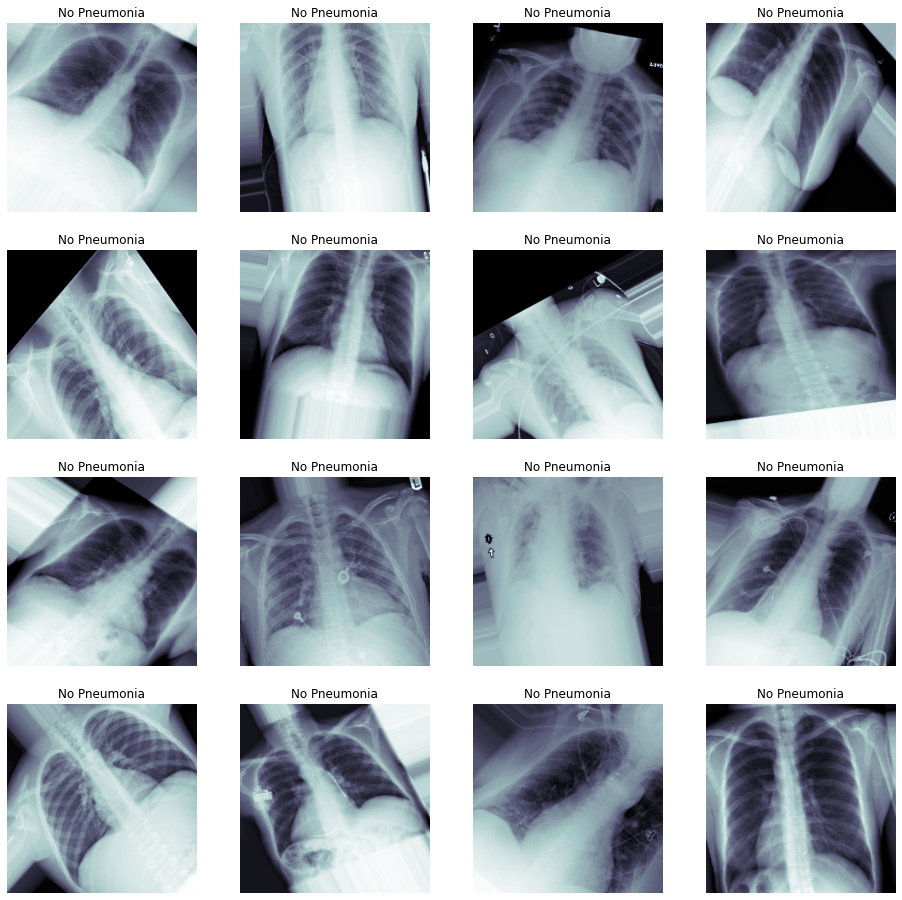

In [57]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [73]:
def load_pretrained_model():
    
    tune_layer = "block5_pool"
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(tune_layer)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    return vgg_model


In [77]:
def build_my_model():
    
    starter_model = load_pretrained_model()
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    # All of this is stock standard from exercises, earlier. Get things running, then optimize. 
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(starter_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1, activation='relu'))
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    # Why are we defining this stuff outside of the function?
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [78]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_accuracy', 
                      mode= 'max', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [79]:
## train your model

# Todo
my_model = build_my_model()

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 5, 
                          callbacks = callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
  15/5606 [..............................] - ETA: 5:09:36 - loss: 1.1606 - binary_accuracy: 0.8875

KeyboardInterrupt: 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)